### Building a basic chatbot with Langgraph (Graph API)

In [21]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # add_messages is a reducer
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()

True

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages`function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list, add_messages]

In [3]:
llm = ChatOpenAI(model="gpt-4o")

In [4]:
# Node functionality
def chatbot(state:State):
    return {'messages': [llm.invoke(state['messages'])]}

In [5]:
graph_builder = StateGraph(State)

# Create a node
graph_builder.add_node("LLMChatbot", chatbot)

# Establish edges
graph_builder.add_edge(START, "LLMChatbot")
graph_builder.add_edge("LLMChatbot", END)

# Complie graph
graph = graph_builder.compile()

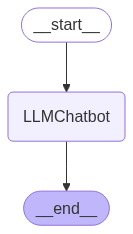

In [6]:
graph

In [7]:
response = graph.invoke({"messages":"Hi"})

In [8]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='02e5c3cf-968f-4fe3-80cd-a9592ae2be94'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C5J7LMvRNRzwqe4PKSTdhEsMQgdBi', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a8c7eac7-9fe6-4c9f-aa4e-5ab63f107691-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [9]:
response['messages'][-1].content

'Hello! How can I assist you today?'

In [13]:
for event in graph.stream({"messages": "Hi, how are you?"}):
    for value in event.values():
        print(value['messages'][-1].content)


Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?


In [15]:
for event in graph.stream({"messages": "Can you give me some recent AI related news along with the date the news was published?"}):
    for value in event.values():
        print(value['messages'][-1].content)


I'm unable to provide real-time news updates, but I can summarize recent trends and developments in AI as of the last known updates. Here are a few key areas that were active up to 2023:

1. **Advancements in Generative AI**: Technologies like GPT-3 and successor models, along with innovations from companies like OpenAI, Google, and DeepMind, have continued to push the boundaries of what AI can generate in terms of text, images, and even music.

2. **Ethical AI and Regulation**: There has been increasing attention to ethical considerations and regulations around AI. Discussions and legislative efforts around AI ethics, bias, and transparency have been highlighted in various forums and countries.

3. **AI in Healthcare**: AI's role in healthcare has been growing, with new applications in diagnostics, personalized medicine, and operational efficiencies being explored and sometimes implemented in clinical settings.

4. **AI for Climate Change**: There has been rising interest in applying 

### Chatbot with tools

In [17]:
searchtool = TavilySearch(max_results=2)
searchtool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [18]:
def multiply(a:int, b:int)->int:
    """
    Multiple a with b.

    a (int): First integer
    b (int): Second integer

    Returns:
        int: output integer product
    """

In [24]:
tools=[searchtool, multiply]
llm_with_tools=llm.bind_tools(tools)

In [26]:
def tools_calling_llm(state:State):
    return {"messages": llm_with_tools.invoke(state['messages'])}

### New StateGraph
builder = StateGraph(State)

## Add Nodes
builder.add_node("ToolCallLLM", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "ToolCallLLM")
# If the lastest message from the assistant is a tool call, tools_condition routes to "Tools"
# If the lastest message from the assistant is not a tool call, tools_condition routes to "END"
builder.add_conditional_edges("ToolCallLLM", tools_condition)
builder.add_edge("tools", END)

# Compile graph
new_graph = builder.compile()

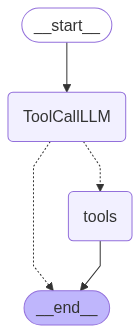

In [27]:
new_graph

In [29]:
new_response = new_graph.invoke({"messages": "Give recent AI news along with the date the news was published."})

In [34]:
new_response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.computerworld.com/article/4035190/genai-tools-are-acting-more-alive-than-ever-they-blackmail-people-replicate-and-escape.html", "title": "GenAI self-preserves by blackmailing people, replicating itself, and escaping - Computerworld", "score": 0.8018276, "published_date": "Mon, 11 Aug 2025 10:04:38 GMT", "content": "news analysis ### OpenAI drops GPT-5: smarter, sharper, and built for the real world Aug 7, 2025 6 mins\\n   news analysis ### Tech employment holds steady as job growth slows and AI-driven roles surge Aug 5, 2025 4 mins\\n   feature ### Driverless cars are becoming jerks — and they’re safer because of it Jul 29, 2025 7 mins\\n   news analysis ### AI chatbots ditch medical disclaimers, putting users at risk, study warns Jul 23, 2025 5 mins [...] feature ### From chatbots to robots: The rise of ‘physical AI’ Jul 21, 2025 9 mins\\n   feature ### Rushing into

In [35]:
import json
json.loads(new_response['messages'][-1].content)['results']

[{'url': 'https://www.computerworld.com/article/4035190/genai-tools-are-acting-more-alive-than-ever-they-blackmail-people-replicate-and-escape.html',
  'title': 'GenAI self-preserves by blackmailing people, replicating itself, and escaping - Computerworld',
  'score': 0.8018276,
  'published_date': 'Mon, 11 Aug 2025 10:04:38 GMT',
  'content': 'news analysis ### OpenAI drops GPT-5: smarter, sharper, and built for the real world Aug 7, 2025 6 mins\n   news analysis ### Tech employment holds steady as job growth slows and AI-driven roles surge Aug 5, 2025 4 mins\n   feature ### Driverless cars are becoming jerks — and they’re safer because of it Jul 29, 2025 7 mins\n   news analysis ### AI chatbots ditch medical disclaimers, putting users at risk, study warns Jul 23, 2025 5 mins [...] feature ### From chatbots to robots: The rise of ‘physical AI’ Jul 21, 2025 9 mins\n   feature ### Rushing into genAI? Prepare for budget blowouts and broken promises Jul 16, 2025 14 mins\n   news analysis 